In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from matplotlib import colors

In [2]:
# IEEE Access
textwidth = 6.9907
columnwidth = 3.35852

figsizes = {
    "full_width_golden_ratio": (textwidth, textwidth / 1.618),
    "full_width_small": (textwidth, textwidth / 2 / 1.618),
    "half_width_golden_ratio": (columnwidth, columnwidth / 1.618),
    "half_width_square": (columnwidth, columnwidth),
}

# Define font for Latex PDF
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}",
        "font.family": "t1-times",
        "font.size": 10.0,
    }
)

# Plot Synthetic results

In [5]:
df = pd.read_csv("./results/synthetic.csv")

df["experiment"] = df[["k_compare", "method_family", "adjustment", "random_model_true",
                       "random_model_pred"]].apply(lambda x: hash(f"{x[0]}-{x[1]}-{x[2]}-{x[3]}-{x[4]}"), axis=1)
df["trial"] = df.groupby("experiment").cumcount()
del df["experiment"]
df

/tmp/ipykernel_452764/159172196.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "random_model_pred"]].apply(lambda x: hash(f"{x[0]}-{x[1]}-{x[2]}-{x[3]}-{x[4]}"), axis=1)


,value,confidence_low,confidence_high,n,k_reference,k_compare,trial,method_family,adjustment,random_model_true,random_model_pred
0,0.500513,0.500513,0.500513,500,10,2,0,RI,NORMALIZED,PERM,PERM
1,-0.000696,-0.000696,-0.000696,500,10,2,0,RI,ADJUSTED,PERM,PERM
2,-0.148872,-0.148872,-0.148872,500,10,2,0,RI,STANDARDIZED,PERM,PERM
3,0.005016,0.005016,0.005016,500,10,2,0,MI,NORMALIZED,PERM,PERM
4,0.500770,0.500770,0.500770,500,10,2,0,RI,NORMALIZED,NUM,NUM
...,...,...,...,...,...,...,...,...,...,...,...
179995,0.888280,0.856787,0.923058,500,10,14,999,MI,STANDARDIZED,NUM,NUM
179996,0.001224,0.001013,0.001453,500,10,18,999,MI,ADJUSTED,NUM,NUM
179997,1.737824,1.692250,1.783516,500,10,18,999,MI,STANDARDIZED,NUM,NUM
179998,0.009879,0.009665,0.010111,500,10,22,999,MI,ADJUSTED,NUM,NUM


In [6]:
#df = pd.read_csv("./results/synthetic.csv")

n_trials = df["trial"].nunique()

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)

# Filter only the highest value for each metric and number of clusters and trial
df = df.sort_values("value", ascending=False).drop_duplicates(
    ["metric_name", "trial"], keep="first"
)

metric_name_mapping = df[['method_family', 'adjustment', 'random_model_pred', 'one_sided', 'metric_name']].drop_duplicates().to_records(index=False)
metric_name_mapping = {(m[0], m[1], m[2], m[3]): m[4] for m in metric_name_mapping}
for method_family in df['method_family'].unique():
    for adjustment in df['adjustment'].unique():
        for one_sided in [True, False]:
            if (method_family, adjustment, 'PERM', one_sided) not in metric_name_mapping:
                metric_name_mapping[(method_family, adjustment, 'PERM', one_sided)] = metric_name_mapping[(method_family, adjustment, 'PERM', not one_sided)]

data = df.groupby(["metric_name", "k_compare"]
                  ).size().unstack().fillna(0).div(n_trials)

## Gridded Plot

In [7]:
method_family = "MI"
one_sided = True

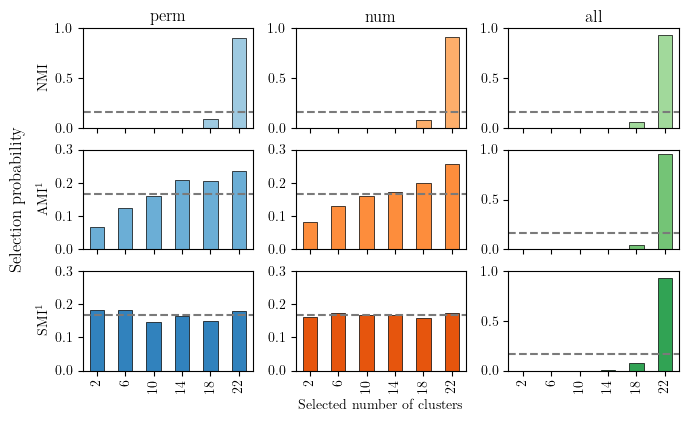

In [8]:
# Plot a grid of bar plots
adjustment_types = ["NORMALIZED", "ADJUSTED", "STANDARDIZED"]
random_models = ["PERM", "NUM", "ALL"]

# Get the tab20c colormap
tab20c = plt.get_cmap("tab20c")

fig, axes = plt.subplots(
    figsize=figsizes["full_width_golden_ratio"], ncols=3, nrows=3, sharex=True, sharey=False)

for i, (axes_row, adjustment_type) in enumerate(zip(axes, adjustment_types)):
    for j, (ax, random_model) in enumerate(zip(axes_row, random_models)):
        metric_name = metric_name_mapping[(method_family, adjustment_type, random_model, one_sided)]
        probabilities = data.loc[metric_name]
        probabilities.plot.bar(
            ax=ax, color=tab20c.colors[4*j+(2-i)], edgecolor="black", linewidth=0.5)
        if probabilities.max() > 0.5:
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, 0.3)
        # Plot horizontal line
        ax.axhline(1 / len(probabilities), color="#7a7a7a", linestyle="dashed")

pad = 5
for ax, col in zip(axes[0], random_models):
    ax.annotate(
        col.lower(),
        xy=(0.5, 1),
        xytext=(0, pad),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="center",
        va="baseline",
    )

for ax, row in zip(axes[:, 0], adjustment_types):
    label = f"{method_family}"
    if not ((row == "NORMALIZED") and (method_family == "RI")):
        label = f"{row[0]}{label}"
    if (row != "NORMALIZED") and one_sided:
        label = label + "$^1$"
    ax.set_ylabel(
        label,
    )

ax = axes[1, 0]
ax.annotate(
    f"Selection probability",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - pad, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    size="large",
    ha="right",
    va="center",
    rotation=90,
)

axes[2, 0].set_xlabel(None)
axes[2, 1].set_xlabel("Selected number of clusters")
axes[2, 2].set_xlabel(None)

fig.tight_layout(h_pad=-0.75)
suffix = "_one_sided" if one_sided else ""
fig.savefig(f"./results/synthetic_{method_family}{suffix}.pdf")

## One vs Two-sided

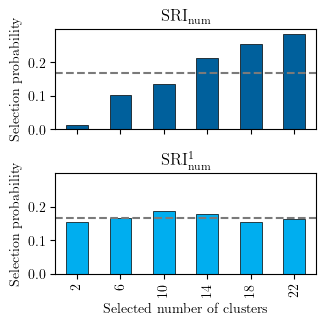

In [9]:
fig, axes = plt.subplots(
    2, 1, figsize=figsizes["half_width_square"], sharey=True, sharex=True)


# Color #00609c
color_1 = "#00609c"

# Color #00aeef
color_2 = "#00aeef"

for ax, color, metric_name in zip(axes, [color_1, color_2], [r"SRI$_\text{num}$", r"SRI$_\text{num}^1$"]):
    probabilities = data.loc[metric_name]
    probabilities.plot.bar(
        ax=ax,
        title=metric_name,
        color=color,
        edgecolor="black",
        linewidth=0.5,
    )
    ax.axhline(1 / len(probabilities), color="#7a7a7a", linestyle="dashed")
    ax.set_ylabel("Selection probability")
    ax.set_xlabel("Selected number of clusters")

fig.tight_layout()
fig.savefig("results/synthetic_one_vs_two_sided.pdf")

# Plot real results

In [10]:
algorithm = "AGGLOMERATIVE_CLUSTERING"
nsigma = 3

In [11]:
df = pd.read_csv("results/real.csv")
df = df[(df['algorithm'] == algorithm) & (df['adjustment'] == 'STANDARDIZED')]

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)


data = df.pivot(
    index="dataset",
    columns="metric_name",
    values=["value", "confidence_low", "confidence_high"],
)


def category_assignment(val, baseline, nsigma=3):
    if not (abs(baseline) > nsigma) and (abs(val) > nsigma):
        return r"insig. $\rightarrow$ sig."
    elif (abs(baseline) > nsigma) and not (abs(val) > nsigma):
        return r"sig. $\rightarrow$ insig."
    elif (not (abs(baseline) > nsigma) and not (abs(val) > nsigma)) or (((val < 0) and (baseline < 0)) or ((val > 0) and (baseline > 0)) and ((abs(baseline) > nsigma) and (abs(val) > nsigma))):
        return r"same"
    else:
        return r"opposite"
    

for metric_name in set(data.columns.levels[1]):
    baseline_metric = metric_name.split("$")[0] + r"$_\text{perm}$"
    data[("category", metric_name)] = data[[("value", metric_name), ("value", baseline_metric)]].apply(
        lambda x: category_assignment(x[0], x[1], nsigma), raw=True, axis=1
    )
data

value                                      \
metric_name        SMI$_\text{all}$ SMI$_\text{all}^1$ SMI$_\text{num}$   
dataset                                                                   
Alizadeh-2000-v1          -8.047028          -0.056849        10.741115   
Alizadeh-2000-v2          -6.542501           8.149059        31.401056   
Alizadeh-2000-v3          -5.335236           5.580363        22.872140   
Armstrong-2002-v1        -11.819882           1.050537        23.108823   
Armstrong-2002-v2         -8.118987           5.415473        33.382242   
Bhattacharjee-2001       -22.801583           1.591691        29.067148   
Bittner-2000              -8.500528          -2.697391        -0.089699   
Bredel-2005               -8.028681           0.504382        10.633686   
Chen-2002                -26.247870          -5.058589        -0.613379   
Chowdary-2006            -17.434276          -2.883345         7.086988   
Dyrskjot-2003             -6.534689           0.034023         8.884532   
Garber-2001              -12.339651          -5.665850        -0.122599   
Golub-1999-v1            -10.131915           4.991562        43.125741   
Golub-1999-v2             -7.752278           7.020583        35.043337   
Gordon-2002              -25.762982          -3.932149        12.070800   
Khan-2001                -10.385312           1.735896        20.020452   
Laiho-2007                -8.249828          -2.355173         2.017078   
Lapointe-2004-v1         -11.713260          -2.750385         6.478402   
Lapointe-2004-v2         -17.094185          -5.340636         5.212568   
Liang-2005                -6.491296          -0.091692         5.802837   
Nutt-2003-v1              -6.575029           0.394002         9.791296   
Nutt-2003-v2              -6.748144          -2.355521         0.089205   
Nutt-2003-v3              -3.416962           2.423147        11.969378   
Pomeroy-2002-v1           -7.955994          -2.986525        -0.499157   
Pomeroy-2002-v2           -2.541306           3.447088        11.433476   
Ramaswamy-2001           -13.901351          -1.841240        16.176535   
Risinger-2003             -8.036798          -3.654345         0.999508   
Shipp-2002-v1            -14.357402          -3.918259         0.080767   
Singh-2002               -17.423981          -3.277297         4.111547   
Su-2001                  -11.810326           4.753476        25.421435   
Tomlins-2006             -11.179727           2.077062        21.530153   
Tomlins-2006-v2          -14.135197          -3.651593         7.987482   
West-2001                -10.111507          -2.723321         1.198586   
Yeoh-2002-v1             -28.603876          11.888964       123.625694   
Yeoh-2002-v2             -27.144485          -2.691976        29.531602   

                                                                          \
metric_name        SMI$_\text{num}^1$ SMI$_\text{perm}$ SRI$_\text{all}$   
dataset                                                                    
Alizadeh-2000-v1            10.940811         10.778074       -12.384203   
Alizadeh-2000-v2            29.793395         30.582218         6.926347   
Alizadeh-2000-v3            22.954725         23.171800        -8.886907   
Armstrong-2002-v1           22.056448         22.412493       -36.953991   
Armstrong-2002-v2           33.845320         35.403753        -5.209109   
Bhattacharjee-2001          28.204540         30.091475      -169.964956   
Bittner-2000                -0.080493         -0.069886       -20.981778   
Bredel-2005                 10.406122         10.584589       -13.649338   
Chen-2002                   -0.617263         -0.612760      -180.971675   
Chowdary-2006                7.163330          6.266305       -77.902861   
Dyrskjot-2003                8.708112         10.497867       -14.256825   
Garber-2001                 -0.313471          0.323424       -42.672581   
Golub-1999-v1               43.625798  

## Get tabular results

In [12]:
results = []
for metric_name in data["category"].columns:
    results.append(data["category"][metric_name].value_counts().rename(metric_name))
results = pd.concat(results, axis=1).fillna(0).astype(int)
print(results.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & SMI$_\text{all}^1$ & SRI$_\text{all}^1$ & SRI$_\text{num}$ & SRI$_\text{num}^1$ & SRI$_\text{all}$ & SMI$_\text{num}^1$ & SMI$_\text{all}$ & SRI$_\text{perm}$ & SMI$_\text{num}$ & SMI$_\text{perm}$ \\
\midrule
sig. $\rightarrow$ insig. & 14 & 3 & 3 & 3 & 4 & 0 & 1 & 0 & 0 & 0 \\
same & 13 & 19 & 24 & 27 & 3 & 35 & 0 & 35 & 35 & 35 \\
insig. $\rightarrow$ sig. & 4 & 3 & 1 & 1 & 7 & 0 & 9 & 0 & 0 & 0 \\
opposite & 4 & 10 & 7 & 4 & 21 & 0 & 25 & 0 & 0 & 0 \\
\bottomrule
\end{tabular}



## Plot individual comparison

/home/kai/mambaforge/envs/random_models/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


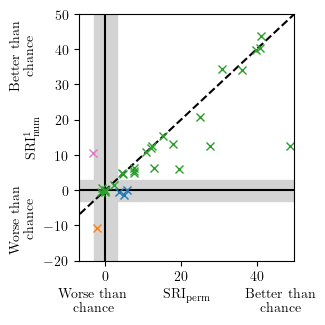

In [13]:
method_1 = r"SRI$_\text{perm}$"
method_2 = r"SRI$_\text{num}^1$"

fig, ax = plt.subplots(figsize=figsizes["half_width_square"])

ax.axvline(0.0, color="black")
ax.axhline(0.0, color="black")


x_lim = [data[('value', method_1)].min(), data[('value', method_1)].max()]
y_lim = [data[('value', method_2)].min(), data[('value', method_2)].max()]

x_lim = [-7, 50]
y_lim = [-20, 50]

ax.fill_between(x_lim, -nsigma, nsigma, color="lightgrey", alpha=1)
ax.fill_between([-nsigma, nsigma], y_lim[0],
                y_lim[1], color="lightgrey", alpha=1)

categories = sorted(data[("category", method_2)].unique())


for category, color in zip(categories, ["tab:orange", "tab:pink", "tab:green", "tab:blue"]):
    df_selected = data[data[("category", method_2)] == category].copy(deep=True)
    if len(df_selected) == 0:
        continue
    # if category != "same":
    #     print(df_selected[[("value", method_1), ("value", method_2)]])

    xerr = [
        df_selected["value"][method_1]
        - df_selected["confidence_low"][method_1],
        df_selected["confidence_high"][method_1]
        - df_selected["value"][method_1],
    ]

    yerr = [
        df_selected["value"][method_2]
        - df_selected["confidence_low"][method_2],
        df_selected["confidence_high"][method_2]
        - df_selected["value"][method_2],
    ]

    # ax.scatter(
    #     df_selected["value"][model_1_str],
    #     df_selected["value"][model_2_str],
    #     color=color,
    #     marker=marker,
    #     s=size,
    #     zorder=10,
    # )
    ax.errorbar(
        df_selected["value"][method_1],
        df_selected["value"][method_2],
        xerr=xerr,
        yerr=yerr,
        fmt='x',
        color=color,
    )

ax.set_aspect("equal")
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xy_min, xy_max = min(x_min, y_min), max(x_max, y_max)
ax.set_xlim([xy_min, xy_max])
ax.set_ylim([xy_min, xy_max])

ax.plot(
    [xy_min, xy_max],
    [xy_min, xy_max],
    color="black",
    linestyle="dashed",
)
ax.set_aspect("auto")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.set_xlabel(method_1)
ax.set_ylabel(method_2)

# Annotations for x-axis on the left and right outside the plot area
ax.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)
ax.annotate(
    "Better than\nchance",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)

# Annotations for y-axis on the top and bottom outside the plot area
ax.annotate(
    "Better than\nchance",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-40, -30),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)
ax.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(-40, 30),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)

# # Add labels I, II, III, IV to the quadrants
# ax.text(0.98, 0.95, r"\textbf{I}", ha="right",
#         va="center", transform=ax.transAxes)
# ax.text(0.02, 0.95, r"\textbf{II}", ha="left",
#         va="center", transform=ax.transAxes)
# ax.text(0.02, 0.05, r"\textbf{III}", ha="left",
#         va="center", transform=ax.transAxes)
# ax.text(0.98, 0.05, r"\textbf{IV}", ha="right",
#         va="center", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(f"./results/SRI_perm_vs_num1.pdf")

## Plot Spearman Correlation

In [14]:
one_sided = False

df = pd.read_csv("results/real.csv")
df = df[df["adjustment"].isin(["ADJUSTED", "STANDARDIZED"])]

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)

df = df[(df['one_sided'] == one_sided) | ((df['random_model_pred'] == "PERM") & (df['random_model_true'] == "PERM"))]

In [15]:
df_pivot = df.pivot(
    columns="metric_name", index=("dataset", "algorithm"), values="value"
)
correlations = df_pivot.corr(method="spearman")

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlations

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method="average")

# Get the order of rows according to the clustering
leaf_order = leaves_list(linkage_matrix)

# Reorder the correlation matrix according to the clustering result
ordered_correlations = correlations.iloc[leaf_order, leaf_order]

ordered_correlations

metric_name,AMI$_\text{all}$,SMI$_\text{all}$,ARI$_\text{all}$,SRI$_\text{all}$,ARI$_\text{num}$,SRI$_\text{num}$,ARI$_\text{perm}$,SRI$_\text{perm}$,SMI$_\text{num}$,SMI$_\text{perm}$,AMI$_\text{num}$,AMI$_\text{perm}$
metric_name,,,,,,,,,,,,
AMI$_\text{all}$,1.000000,0.799844,0.758471,0.711205,0.282921,0.170182,0.654019,0.528610,0.440597,0.471940,0.688019,0.677207
SMI$_\text{all}$,0.799844,1.000000,0.846757,0.887464,0.311516,0.191201,0.329117,0.096642,0.017687,-0.007487,0.324061,0.276407
ARI$_\text{all}$,0.758471,0.846757,1.000000,0.980183,0.594359,0.477002,0.564195,0.338303,0.288672,0.248632,0.513135,0.465955
SRI$_\text{all}$,0.711205,0.887464,0.980183,1.000000,0.539557,0.420336,0.462011,0.221045,0.175498,0.129254,0.410308,0.360064
ARI$_\text{num}$,0.282921,0.311516,0.594359,0.539557,1.000000,0.969417,0.518556,0.384774,0.488518,0.402129,0.450490,0.390333
SRI$_\text{num}$,0.170182,0.191201,0.477002,0.420336,0.969417,1.000000,0.434428,0.337114,0.470547,0.386283,0.371505,0.315046
ARI$_\text{perm}$,0.654019,0.329117,0.564195,0.462011,0.518556,0.434428,1.000000,0.924137,0.781918,0.780579,0.875699,0.896309
SRI$_\text{perm}$,0.528610,0.096642,0.338303,0.221045,0.384774,0.337114,0.924137,1.000000,0.854767,0.884446,0.824316,0.868128
SMI$_\text{num}$,0.440597,0.017687,0.288672,0.175498,0.488518,0.470547,0.781918,0.854767,1.000000,0.970730,0.917119,0.909983


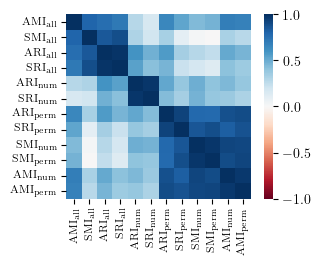

In [16]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=figsizes["half_width_square"])
ax = sns.heatmap(ordered_correlations, annot=False,
                 cmap="RdBu", vmin=-1.0, vmax=1.0)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_aspect("equal")

# Use this if ordered_correlations is a DataFrame
labels = ordered_correlations.columns
# If ordered_correlations is not a DataFrame but a numpy array, you might set labels manually
# labels = ['label1', 'label2', 'label3', ...]

# Set x and y ticks
tick_positions = np.arange(0.5, len(labels) + 0.5, 1)
ax.set_xticks(tick_positions)
ax.set_xticklabels(
    labels, rotation=90
)  # Rotate for better orientation if needed

ax.set_yticks(tick_positions)
ax.set_yticklabels(labels)  # Assuming you want labels on y-axis as well

ax.tick_params(axis="x", labelsize=8)  # Adjust x-axis label size
ax.tick_params(axis="y", labelsize=8)  # Adjust y-axis label size
fig.tight_layout()

# Find the colorbar attached to the axis
cbar = ax.collections[0].colorbar

# Adjust the colorbar size
# Here, we're setting the fraction (relative size of the colorbar) and the pad (distance from the heatmap)
cbar.ax.set_aspect(10)
cbar.ax.set_position(
    [ax.get_position().x1 + 0.04, ax.get_position().y0,
     0.03, ax.get_position().height]
)

suffix = "_one_sided" if one_sided else ""

plt.savefig(f"./results/spearman_correlation_heatmap{suffix}.pdf")

## Joint plot

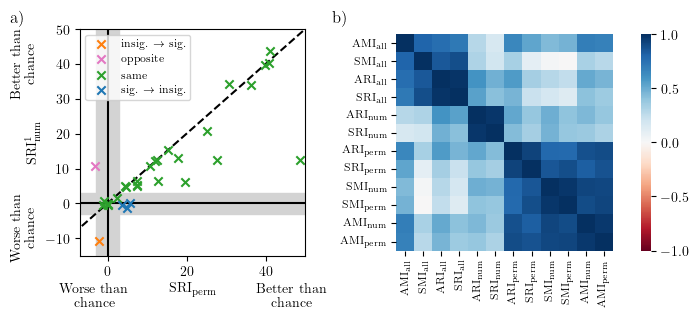

In [17]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(textwidth, textwidth / 2.2), gridspec_kw={"width_ratios": [1, 1.2]}
)

# Figure a)
method_1 = r"SRI$_\text{perm}$"
method_2 = r"SRI$_\text{num}^1$"

ax1.axvline(0.0, color="black", zorder = -1)
ax1.axhline(0.0, color="black", zorder = -1)


x_lim = [data[("value", method_1)].min(), data[("value", method_1)].max()]
y_lim = [data[("value", method_2)].min(), data[("value", method_2)].max()]

x_lim = [-7, 50]
y_lim = [-15, 50]

ax1.fill_between(x_lim, -nsigma, nsigma, color="lightgrey", alpha=1, zorder = -2)
ax1.fill_between([-nsigma, nsigma], y_lim[0], y_lim[1], color="lightgrey", alpha=1, zorder= -2)

categories = sorted(data[("category", method_2)].unique())


for category, color in zip(
    categories, ["tab:orange", "tab:pink", "tab:green", "tab:blue"]
):
    df_selected = data[data[("category", method_2)] == category].copy(deep=True)
    if len(df_selected) == 0:
        continue
    # if category != "same":
    #     print(df_selected[[("value", method_1), ("value", method_2)]])

    xerr = [
        df_selected["value"][method_1] - df_selected["confidence_low"][method_1],
        df_selected["confidence_high"][method_1] - df_selected["value"][method_1],
    ]

    yerr = [
        df_selected["value"][method_2] - df_selected["confidence_low"][method_2],
        df_selected["confidence_high"][method_2] - df_selected["value"][method_2],
    ]

    ax1.scatter(
        df_selected["value"][method_1],
        df_selected["value"][method_2],
        color=color,
        marker="x",
        label=category,
    )
    # ax1.errorbar(
    #     df_selected["value"][method_1],
    #     df_selected["value"][method_2],
    #     xerr=xerr,
    #     yerr=yerr,
    #     fmt="x",
    #     color=color,
    #     label=category,
    # )

ax1.set_aspect("equal")
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()
xy_min, xy_max = min(x_min, y_min), max(x_max, y_max)
ax1.set_xlim([xy_min, xy_max])
ax1.set_ylim([xy_min, xy_max])

ax1.plot(
    [xy_min, xy_max],
    [xy_min, xy_max],
    color="black",
    linestyle="dashed",
    zorder=-1
)
ax1.set_aspect("auto")


ax1.legend(loc="upper left", fontsize=8,)

ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)

ax1.set_xlabel(method_1)
ax1.set_ylabel(method_2)

# Annotations for x-axis on the left and right outside the plot area
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)
ax1.annotate(
    "Better than\nchance",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)

# Annotations for y-axis on the top and bottom outside the plot area
ax1.annotate(
    "Better than\nchance",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-40, -25),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(-40, 20),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)


# # Add labels I, II, III, IV to the quadrants
# ax1.text(0.98, 0.95, r"\textbf{I}", ha="right",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.95, r"\textbf{II}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.05, r"\textbf{III}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.98, 0.05, r"\textbf{IV}", ha="right",
#         va="center", transform=ax1.transAxes)

fig.tight_layout()
# Add the labels
fig.text(0.02, 1.0, "a)", fontsize=12, weight="bold", ha="left", va="top")
fig.text(0.48, 1.0, "b)", fontsize=12, weight="bold", ha="left", va="top")

# Figure b)

# Plot the correlation matrix
ax2 = sns.heatmap(ordered_correlations, annot=False, cmap="RdBu", vmin=-1.0, vmax=1.0)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_aspect("equal")

# Use this if ordered_correlations is a DataFrame
labels = ordered_correlations.columns
# If ordered_correlations is not a DataFrame but a numpy array, you might set labels manually
# labels = ['label1', 'label2', 'label3', ...]

# Set x and y ticks
tick_positions = np.arange(0.5, len(labels) + 0.5, 1)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(labels, rotation=90)  # Rotate for better orientation if needed

ax2.set_yticks(tick_positions)
ax2.set_yticklabels(labels)  # Assuming you want labels on y-axis as well

ax2.tick_params(axis="x", labelsize=8)  # Adjust x-axis label size
ax2.tick_params(axis="y", labelsize=8)  # Adjust y-axis label size
fig.tight_layout()

# Find the colorbar attached to the axis
cbar = ax2.collections[0].colorbar

# Adjust the colorbar size
# Here, we're setting the fraction (relative size of the colorbar) and the pad (distance from the heatmap)
cbar.ax.set_aspect('auto')
cbar.ax.set_position(
    [
        ax2.get_position().x1 + 0.04,
        ax2.get_position().y0,
        0.03,
        ax2.get_position().height,
    ]
)

fig.savefig("./results/mcpdesouto.pdf")

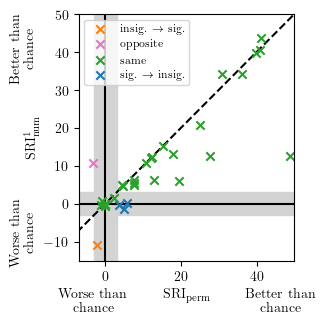

In [18]:
fig, ax1 = plt.subplots(figsize=figsizes["half_width_square"])

# Figure a)
method_1 = r"SRI$_\text{perm}$"
method_2 = r"SRI$_\text{num}^1$"

ax1.axvline(0.0, color="black", zorder=-1)
ax1.axhline(0.0, color="black", zorder=-1)


x_lim = [data[("value", method_1)].min(), data[("value", method_1)].max()]
y_lim = [data[("value", method_2)].min(), data[("value", method_2)].max()]

x_lim = [-7, 50]
y_lim = [-15, 50]

ax1.fill_between(x_lim, -nsigma, nsigma, color="lightgrey", alpha=1, zorder=-2)
ax1.fill_between(
    [-nsigma, nsigma], y_lim[0], y_lim[1], color="lightgrey", alpha=1, zorder=-2
)

categories = sorted(data[("category", method_2)].unique())


for category, color in zip(
    categories, ["tab:orange", "tab:pink", "tab:green", "tab:blue"]
):
    df_selected = data[data[("category", method_2)] == category].copy(deep=True)
    if len(df_selected) == 0:
        continue
    # if category != "same":
    #     print(df_selected[[("value", method_1), ("value", method_2)]])

    xerr = [
        df_selected["value"][method_1] - df_selected["confidence_low"][method_1],
        df_selected["confidence_high"][method_1] - df_selected["value"][method_1],
    ]

    yerr = [
        df_selected["value"][method_2] - df_selected["confidence_low"][method_2],
        df_selected["confidence_high"][method_2] - df_selected["value"][method_2],
    ]

    ax1.scatter(
        df_selected["value"][method_1],
        df_selected["value"][method_2],
        color=color,
        marker="x",
        label=category,
    )
    # ax1.errorbar(
    #     df_selected["value"][method_1],
    #     df_selected["value"][method_2],
    #     xerr=xerr,
    #     yerr=yerr,
    #     fmt="x",
    #     color=color,
    #     label=category,
    # )

ax1.set_aspect("equal")
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()
xy_min, xy_max = min(x_min, y_min), max(x_max, y_max)
ax1.set_xlim([xy_min, xy_max])
ax1.set_ylim([xy_min, xy_max])

ax1.plot(
    [xy_min, xy_max], [xy_min, xy_max], color="black", linestyle="dashed", zorder=-1
)
ax1.set_aspect("auto")


ax1.legend(
    loc="upper left",
    fontsize=8,
)

ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)

ax1.set_xlabel(method_1)
ax1.set_ylabel(method_2)

# Annotations for x-axis on the left and right outside the plot area
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)
ax1.annotate(
    "Better than\nchance",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)

# Annotations for y-axis on the top and bottom outside the plot area
ax1.annotate(
    "Better than\nchance",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-40, -25),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(-40, 20),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)


# # Add labels I, II, III, IV to the quadrants
# ax1.text(0.98, 0.95, r"\textbf{I}", ha="right",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.95, r"\textbf{II}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.05, r"\textbf{III}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.98, 0.05, r"\textbf{IV}", ha="right",
#         va="center", transform=ax1.transAxes)

fig.tight_layout()
fig.savefig("./results/mcpdesouto1.pdf")

In [19]:
print(data.columns)
print(data.head())

MultiIndex([(          'value',   'SMI$_\text{all}$'),
            (          'value', 'SMI$_\text{all}^1$'),
            (          'value',   'SMI$_\text{num}$'),
            (          'value', 'SMI$_\text{num}^1$'),
            (          'value',  'SMI$_\text{perm}$'),
            (          'value',   'SRI$_\text{all}$'),
            (          'value', 'SRI$_\text{all}^1$'),
            (          'value',   'SRI$_\text{num}$'),
            (          'value', 'SRI$_\text{num}^1$'),
            (          'value',  'SRI$_\text{perm}$'),
            ( 'confidence_low',   'SMI$_\text{all}$'),
            ( 'confidence_low', 'SMI$_\text{all}^1$'),
            ( 'confidence_low',   'SMI$_\text{num}$'),
            ( 'confidence_low', 'SMI$_\text{num}^1$'),
            ( 'confidence_low',  'SMI$_\text{perm}$'),
            ( 'confidence_low',   'SRI$_\text{all}$'),
            ( 'confidence_low', 'SRI$_\text{all}^1$'),
            ( 'confidence_low',   'SRI$_\text{num}$'),
          

## Performance evaluation

In [ ]:
df.read_csv("results/efficiency_experiment_combined.csv")

In [36]:
grouped_df = df.groupby(["n", "method", "random_model"]).agg(
    {"runtime_seconds": ["mean", "std", "count"]}
)
grouped_df.columns = ["mean", "std", "count"]
grouped_df = grouped_df[grouped_df["count"] == grouped_df["count"].max()]
grouped_df = grouped_df[['mean', 'std']].reset_index()
grouped_df = grouped_df.pivot(index="n", columns=["method", "random_model"], values=["mean", "std"])
grouped_df

mean                                                       \
method              SMI                          SMI_MC                        
random_model        ALL        NUM       PERM       ALL        NUM      PERM   
n                                                                              
10             1.423105   0.831666   0.031781  0.327720   0.489016  0.307601   
12             4.048462   2.952126        NaN       NaN        NaN       NaN   
13                  NaN        NaN   0.099016       NaN        NaN       NaN   
14            10.041644   8.161240        NaN       NaN        NaN       NaN   
16            22.534986  19.425100        NaN       NaN        NaN       NaN   
17                  NaN        NaN   0.248440       NaN        NaN       NaN   
18            46.259963  41.504172        NaN       NaN        NaN       NaN   
20            88.981336  81.698942        NaN       NaN        NaN       NaN   
23                  NaN        NaN   0.583677       NaN        NaN       NaN   
31                  NaN        NaN   1.498889  0.332274   0.847582  0.308247   
42                  NaN        NaN   4.128678       NaN        NaN       NaN   
56                  NaN        NaN  11.878837       NaN        NaN       NaN   
74                  NaN        NaN  29.348914       NaN        NaN       NaN   
100                 NaN        NaN        NaN  0.340935   2.308747  0.319740   
316                 NaN        NaN        NaN  0.379138   6.348964  0.347956   
1000                NaN        NaN        NaN  0.472333  19.521326  0.411447   
3162                NaN        NaN        NaN  0.753444  61.597490  0.587108   
10000               NaN        NaN        NaN  1.663922        NaN  1.156979   

                                                 std                       \
method             SRI                           SMI                        
random_model       ALL       NUM      PERM       ALL       NUM       PERM   
n                                                                           
10            0.010944  0.001004  0.000881  0.010427  0.015978   0.007626   
12                 NaN       NaN       NaN  0.032459  0.044218        NaN   
13                 NaN       NaN       NaN       NaN       NaN   0.061130   
14                 NaN       NaN       NaN  0.107745  0.081994        NaN   
16                 NaN       NaN       NaN  0.286853  0.246450        NaN   
17                 NaN       NaN       NaN       NaN       NaN   0.129748   
18                 NaN       NaN       NaN  0.612638  0.584325        NaN   
20                 NaN       NaN       NaN  0.938839  0.957799        NaN   
23                 NaN       NaN       NaN       NaN       NaN   0.292889   
31            0.013695  0.001114  0.000950       NaN       NaN   0.823483   
42                 NaN       NaN       NaN       NaN       NaN   1.808641   
56                 NaN       NaN       NaN       NaN       NaN   5.833116   
74                 NaN       NaN       NaN       NaN       NaN  13.542223   
100           0.021907  0.001104  0.000988       NaN       NaN        NaN   
316           0.050559  0.001228  0.001107       NaN       NaN        NaN   
1000          0.114143  0.001444  0.001265       NaN       NaN        NaN   
3162          0.299837  0.002174  0.001980       NaN       NaN        NaN   
10000         0.829933  0.005722  0.005638       NaN       NaN        NaN   

                                                                          
method          SMI_MC                           SRI                      
random_model       ALL       NUM      PERM       ALL       NUM      PERM  
n                                                                         
10            0.006694  0.008529  0.006774  0.000133  0.000030  0.000027  
12                 NaN       NaN       NaN       NaN       NaN       NaN  
13                 NaN       NaN       NaN       NaN       NaN       NaN  
14                 NaN       NaN      

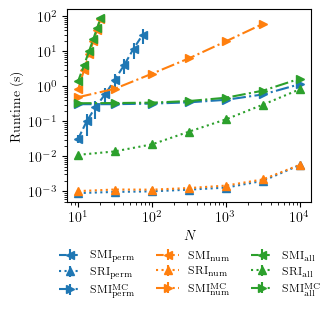

In [51]:
fig, ax1 = plt.subplots(figsize=figsizes["half_width_square"])




for random_model, color in zip(["PERM", "NUM", "ALL"], ["tab:blue", "tab:orange", "tab:green"]):
    for method, ls, marker in zip(["SMI", "SRI", "SMI_MC"], ["dashed", "dotted", "dashdot"], ["<", "^", ">"]):
        series = grouped_df["mean"][method][random_model].dropna()
        err = grouped_df["std"][method][random_model].dropna()

        label = f"{method}$"
        if method == "SMI_MC":
            label = r"SMI$^\text{MC}"
        label += f"_\\text{{{random_model.lower()}}}$"

        ax1.errorbar(
            series.index,
            series,
            err,
            marker=marker,
            linestyle=ls,
            color=color,
            label=label,
        )

# Generate legend below the plot
ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    fontsize=8,
    frameon=False,
)


ax1.set_xlabel("$N$")
ax1.set_ylabel("Runtime (s)")

ax1.set_yscale("log")
ax1.set_xscale("log")

fig.tight_layout()
fig.savefig("results/efficiency_experiment.pdf")